In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
from tueplots import bundles
plt.rcParams.update(bundles.beamer_moml())

# Also add despine to the bundle using rcParams
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

# Increase font size to match Beamer template
plt.rcParams["font.size"] = 16
# Make background transparent
plt.rcParams["figure.facecolor"] = "none"
# use font size Roboto Condensed
plt.rcParams["font.family"] = "sans-serif"

In [3]:
if torch.cuda.is_available():
     torch.cuda.set_device(1)
     torch.set_default_tensor_type(torch.cuda.FloatTensor)

/home/cvig/anaconda3/envs/pml/lib/python3.11/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /opt/conda/conda-bld/pytorch_1695392035891/work/torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)


In [4]:
context_size = 10
hidden_size = 128  # Number of neurons in each hidden layer of base model and number of ouput of adaptive network
num_output_adaptive = hidden_size
num_output_setEncoderContext = 128
input_size_adaptation_network = num_output_setEncoderContext

In [5]:
# Define a simple MLP model for regression with 5 hidden layers
num_layers_MLPRegressor = 4         # except the last layer - to be used for number of gamma and beta parameters

class MLPRegressor(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(MLPRegressor, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.fc5 = nn.Linear(hidden_size, 1)  # Output layer with one node for regression

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        out = self.relu(out)
        out = self.fc4(out)
        out = self.relu(out)
        out = self.fc5(out)
        return out

In [6]:
# Define a simple MLP model for regression with 5 hidden layers
class adaptiveMLPRegressor(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(adaptiveMLPRegressor, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.fc5 = nn.Linear(hidden_size, 1)  # Output layer with one node for regression
        
    def forward(self, x, gamma_beta_lst):
        out = self.fc1(x)
        out = self.relu(out)
        out = out * gamma_beta_lst[0]['gamma'] + gamma_beta_lst[0]['beta']

        out = self.fc2(out)
        out = self.relu(out)
        out = out * gamma_beta_lst[1]['gamma'] + gamma_beta_lst[1]['beta']

        out = self.fc3(out)
        out = self.relu(out)
        out = out * gamma_beta_lst[2]['gamma'] + gamma_beta_lst[2]['beta']

        out = self.fc4(out)
        out = self.relu(out)
        out = out * gamma_beta_lst[3]['gamma'] + gamma_beta_lst[3]['beta']

        out = self.fc5(out)
        
        return out

In [7]:
class setEncoderContext(nn.Module):
    def __init__(self, hidden_size):
        super(setEncoderContext, self).__init__()
        self.fc1 = nn.Linear(2, hidden_size)            # input_size = 2 (for x and y point)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)  # Output layer with one node for regression
        self.fc3 = nn.Linear(hidden_size, hidden_size)  # Output layer with one node for regression
        self.fc4 = nn.Linear(hidden_size, hidden_size)  # Output layer with one node for regression
        self.fc5 = nn.Linear(hidden_size, hidden_size)  # Output layer with one node for regression
        self.fc6 = nn.Linear(hidden_size, num_output_setEncoderContext)  # Output layer with one node for regression
        
    def forward(self, x_y):     # x_y corresponds to a single point
        out = self.fc1(x_y)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        out = self.relu(out)
        out = self.fc4(out)
        out = self.relu(out)
        out = self.fc5(out)
        out = self.relu(out)
        out = self.fc6(out)
        return out    

In [8]:
setEncoderContextNetwork = setEncoderContext(hidden_size)

In [9]:
# def getEmbeddings(X, y):
#     embeding = torch.concat((X, y), dim=0).flatten()
#     # print(embeding.shape)
#     # assert embeding.shape[0] == 40
#     return embeding


def getEmbeddings(X, y):
    # print("Inside getEmbeddings: ", X.shape, y.shape)
    X_y = torch.cat((X.unsqueeze(1), y.unsqueeze(1)), dim=1)
    embeding = setEncoderContextNetwork(X_y)
    embeding = embeding.mean(dim=0)            # Average over all the points in the set, size = (1, num_output_setEncoderContext)
    # embeding = embeding.squeeze()           # size = (num_output_setEncoderContext)
    # embeding = embeding.unsqueeze(1)        # size = (num_output_setEncoderContext, 1)
    # print(embeding.shape)
    # assert embeding.shape[0] == 40
    return embeding

In [10]:
class gammaAdaptationNetwork(nn.Module):
    def __init__(self, input_size_adaptation_network, hidden_size):
        super(gammaAdaptationNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size_adaptation_network, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)  # Output layer with one node for regression
        self.fc3 = nn.Linear(hidden_size, hidden_size)  # Output layer with one node for regression
        self.fc4 = nn.Linear(hidden_size, hidden_size)  # Output layer with one node for regression
        self.fc5 = nn.Linear(hidden_size, hidden_size)  # Output layer with one node for regression
        self.fc6 = nn.Linear(hidden_size, num_output_adaptive)  # Output layer with one node for regression
        
    def forward(self, embeddings):
        out = self.fc1(embeddings)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        out = self.relu(out)
        out = self.fc4(out)
        out = self.relu(out)
        out = self.fc5(out)
        out = self.relu(out)
        out = self.fc6(out)
        return out

In [11]:
class betaAdaptationNetwork(nn.Module):
    def __init__(self, input_size_adaptation_network, hidden_size):
        super(betaAdaptationNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size_adaptation_network, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)  # Output layer with one node for regression
        self.fc3 = nn.Linear(hidden_size, hidden_size)  # Output layer with one node for regression
        self.fc4 = nn.Linear(hidden_size, hidden_size)  # Output layer with one node for regression
        self.fc5 = nn.Linear(hidden_size, hidden_size)  # Output layer with one node for regression
        self.fc6 = nn.Linear(hidden_size, num_output_adaptive)  # Output layer with one node for regression
        
    def forward(self, embeddings):
        out = self.fc1(embeddings)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        out = self.relu(out)
        out = self.fc4(out)
        out = self.relu(out)
        out = self.fc5(out)
        out = self.relu(out)
        out = self.fc6(out)
        return out

In [12]:
class adaptationNetwork(nn.Module):
    def __init__(self, input_size_adaptation_network, hidden_size):
        super(adaptationNetwork, self).__init__()

        self.gammaNetProcessors, self.betaNetProcessors = torch.nn.ModuleList(), torch.nn.ModuleList()

        for i in range(num_layers_MLPRegressor):
            self.gammaNetProcessors.append(gammaAdaptationNetwork(input_size_adaptation_network, hidden_size))
            self.betaNetProcessors.append(betaAdaptationNetwork(input_size_adaptation_network, hidden_size))
        
    def forward(self, X, y):
        gamma_beta_lst = []
        embeddings = getEmbeddings(X, y)
        for i in range(num_layers_MLPRegressor):
            gamma_beta_dict = {'gamma': self.gammaNetProcessors[i](embeddings), 'beta': self.betaNetProcessors[i](embeddings)}
            gamma_beta_lst.append(gamma_beta_dict)
        return gamma_beta_lst

In [13]:
# def get_sine(sine_params, X, i):
#     torch.manual_seed(0)
#     return sine_params[i][0] * torch.sin(sine_params[i][1] * X + sine_params[i][2]) + sine_params[i][3] + torch.randn(X.shape) * 0.1

def get_sine(sine_params, X, i):
    torch.manual_seed(0)
    return sine_params[i][0] * torch.sin(X + sine_params[i][1]) + torch.randn(X.shape) * 0.1

In [14]:
# sine_params = torch.tensor(sine_params)
torch.manual_seed(0)
num_datasets = 101
num_points_per_dataset = 500

A = torch.distributions.Uniform(0.5, 5).sample((num_datasets,))
phi = torch.distributions.Uniform(0, 2 * np.pi).sample((num_datasets,))
sine_params = torch.stack((A, phi), dim=1)

# Generate synthetic data for regression
torch.manual_seed(0)
dataset = [None] * num_datasets  # List of datasets for each function

for i in range(num_datasets):
    # upper_bound = 2 * torch.pi / sine_params[i][1]
    upper_bound = 2 * torch.pi
    X = torch.linspace(0, upper_bound, num_points_per_dataset)
    y = get_sine(sine_params, X, i)  # Sine function with noise
    X_y = torch.cat((X.unsqueeze(1), y.unsqueeze(1)), 1)
    dataset[i] = X_y

/tmp/ipykernel_1083998/1521230445.py:3: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(hspace=0.6)


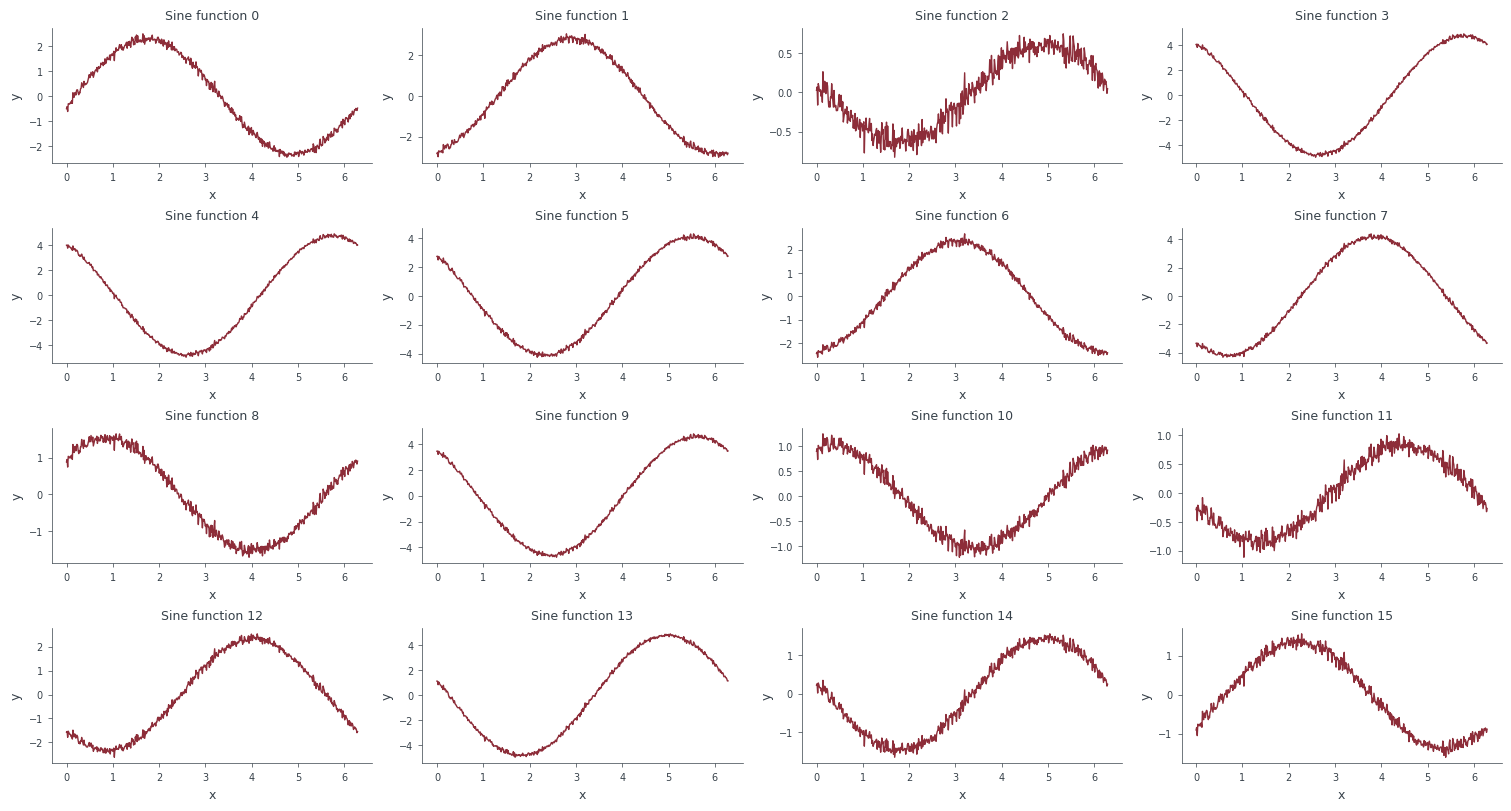

In [15]:
# plot 15 sine functions and adjust margins
plt.figure(figsize=(15, 8))
plt.subplots_adjust(hspace=0.6)

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.plot(dataset[i][:, 0].cpu(), dataset[i][:, 1].cpu())
    plt.title('Sine function {}'.format(i))
    plt.xlabel('x')
    plt.ylabel('y')

In [16]:
print('len(dataset): ', len(dataset))
print('len(dataset[0]): ', len(dataset[0]))
print('dataset[0].type(): ', dataset[0].type())

len(dataset):  101
len(dataset[0]):  500
dataset[0].type():  torch.cuda.FloatTensor


In [17]:
newdataset = []
num_datapoints_per_small_task = 50      # this is the number of datapoints we will use for each iteration of meta learning

for i in range(0, len(dataset)):
    torch.manual_seed(i)
    num_elements = dataset[i].shape[0]
    permuted_indices = torch.randperm(num_elements) # Generate a random permutation of indices
    dataset[i] = dataset[i][permuted_indices]

    # i=0 case will be used for training of main network, therefore, kept intact. Others will be used for meta learning and testing, therefore devided in chunks of 50
    if i>=1:
        for j in range(int(dataset[i].shape[0] / num_datapoints_per_small_task)):
            newdataset.append(dataset[i][j*num_datapoints_per_small_task:(j+1)*num_datapoints_per_small_task,:])

In [18]:
print('len(newdataset): ', len(newdataset))
print('len(newdataset[0]): ', len(newdataset[0]))
# print('newdataset[0]: ', newdataset[0])
# print('newdataset[1]: ', newdataset[1])

len(newdataset):  1000
len(newdataset[0]):  50


In [19]:
# train and test split for meta learning
random.seed(0)
train_dataset = newdataset[:int(len(newdataset)*0.8)]
random.shuffle(train_dataset)       # Shuffle the dataset in-place
test_dataset = newdataset[int(len(newdataset)*0.8):]
random.shuffle(test_dataset)

In [20]:
# Training base model

# Hyperparameters
input_size = 1  # One input feature
learning_rate_base_model = 0.01
num_epochs_base_model = 200
split_ratio_base_model = 0.8    # for training and validation of base model

# Initialize the MLP regression baseModel
baseModel = MLPRegressor(input_size, hidden_size)

# Loss and optimizer
criterion = nn.MSELoss()  # Mean Squared Error loss for regression
optimizer = optim.Adam(baseModel.parameters(), lr=learning_rate_base_model)

# Training loop
for epoch in range(num_epochs_base_model):
    # Forward pass
    outputs = baseModel(dataset[0][:int(num_points_per_dataset*split_ratio_base_model), 0].unsqueeze(1))
    loss = criterion(outputs, dataset[0][:int(num_points_per_dataset*split_ratio_base_model), 1].unsqueeze(1))

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs_base_model}], Loss: {loss.item():.4f}')

# Make predictions
with torch.no_grad():
    # predicted = baseModel(X)
    predicted = baseModel(dataset[0][int(num_points_per_dataset*split_ratio_base_model):, 0].unsqueeze(1))

# print("Predicted values:")
# print(predicted)

# Save the trained baseModel
torch.save(baseModel.state_dict(), 'checkpoints/baseModel.ckpt')
print('MLP regression baseModel with 5 hidden layers trained and saved!')

/home/cvig/anaconda3/envs/pml/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch [100/200], Loss: 0.0316
Epoch [200/200], Loss: 0.0110
MLP regression baseModel with 5 hidden layers trained and saved!


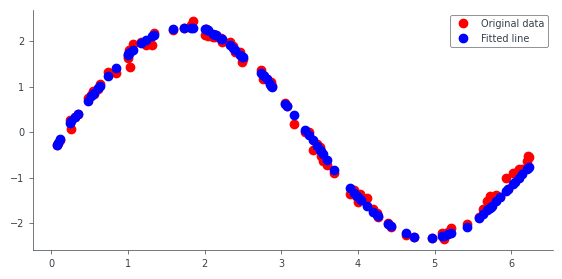

In [21]:
# plot x and y
plt.plot(dataset[0][int(num_points_per_dataset*split_ratio_base_model):, 0].unsqueeze(1).cpu(), dataset[0][int(num_points_per_dataset*split_ratio_base_model):, 1].unsqueeze(1).cpu(), 'ro', label='Original data')
plt.plot(dataset[0][int(num_points_per_dataset*split_ratio_base_model):, 0].unsqueeze(1).cpu(), predicted.cpu(), 'bo', label='Fitted line')
plt.legend()
plt.show()

In [21]:
# Training meta model

# Hyperparameters
learning_rate_adaptive_network = 0.001
num_epochs_adaptive_network = 200

# Initialize the MLP regression baseModel
adaptiveMLPRegModel = adaptiveMLPRegressor(input_size, hidden_size)

# load the trained baseModel
adaptiveMLPRegModel.load_state_dict(torch.load('checkpoints/baseModel.ckpt'))
adaptiveNetwork = adaptationNetwork(input_size_adaptation_network, hidden_size)

# freez the weights of the baseModel
for param in adaptiveMLPRegModel.parameters():
    param.requires_grad = False

# Loss and optimizer
criterion = nn.MSELoss()  # Mean Squared Error loss for regression
optimizer = optim.Adam(adaptiveNetwork.parameters(), lr=learning_rate_adaptive_network)

train_loss_lst = []
test_loss_lst = []

# Training loop
for epoch in range(num_epochs_adaptive_network):
    loss_sum = 0
    for training_task in train_dataset:
        context = training_task[:context_size]
        target_x = training_task[context_size:, 0].unsqueeze(1)
        target_y = training_task[context_size:, 1].unsqueeze(1)
        gamma_beta_lst = adaptiveNetwork.forward(context[:, 0], context[:, 1])

        predictions = adaptiveMLPRegModel(target_x, gamma_beta_lst)
        loss = criterion(predictions, target_y)
        loss_sum += loss.item()
        # print(f'Epoch [{epoch+1}/{num_epochs_adaptive_network}], Loss: {loss.item():.4f}')
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    if (epoch + 1) % 1 == 0:
        train_loss_lst.append(loss_sum/len(train_dataset))
        print(f'Epoch [{epoch+1}/{num_epochs_adaptive_network}], Train Loss: {loss_sum/len(train_dataset)}')

        # Make predictions
        with torch.no_grad():
            loss_sum_test = 0
            for test_task in test_dataset:
                context = test_task[:context_size]
                target_x = test_task[context_size:, 0].unsqueeze(1)
                target_y = test_task[context_size:, 1].unsqueeze(1)
                gamma_beta_dict = adaptiveNetwork.forward(context[:, 0], context[:, 1])
                predictions = adaptiveMLPRegModel(target_x, gamma_beta_dict)
                loss = criterion(predictions, target_y)
                loss_sum_test += loss.item()
            test_loss_lst.append(loss_sum_test/len(test_dataset))
        print(f'Epoch [{epoch+1}/{num_epochs_adaptive_network}], Test Loss: {loss_sum_test/len(test_dataset)}')
    
    if (epoch + 1) % 100 == 0:
        torch.save(adaptiveMLPRegModel.state_dict(), f'checkpoints/adaptiveNetwork_epoch_{epoch+1}.ckpt')

# print("Predicted values:")
# print(predicted)

# Save the trained adaptiveMLPRegModel
torch.save(adaptiveMLPRegModel.state_dict(), f'checkpoints/adaptiveNetwork_epoch_{num_epochs_adaptive_network+1}.ckpt')
print('adaptiveMLPRegModel trained and saved!')

Epoch [1/200], Train Loss: 4.981673596370965
Epoch [1/200], Test Loss: 5.355089482925832
Epoch [2/200], Train Loss: 4.980570541061461
Epoch [2/200], Test Loss: 5.354823501221835
Epoch [3/200], Train Loss: 4.98056603539735
Epoch [3/200], Test Loss: 5.356105135865509
Epoch [4/200], Train Loss: 4.97768878383562
Epoch [4/200], Test Loss: 5.369995295330882
Epoch [5/200], Train Loss: 4.96804116579704
Epoch [5/200], Test Loss: 5.38360593251884
Epoch [6/200], Train Loss: 4.9636479886993765
Epoch [6/200], Test Loss: 5.389464243501425
Epoch [7/200], Train Loss: 4.961675141565502
Epoch [7/200], Test Loss: 5.39500948600471
Epoch [8/200], Train Loss: 4.9605710703320804
Epoch [8/200], Test Loss: 5.398882352337242
Epoch [9/200], Train Loss: 4.959267812529578
Epoch [9/200], Test Loss: 5.4019813687354326
Epoch [10/200], Train Loss: 4.958439735174179
Epoch [10/200], Test Loss: 5.404145755246281
Epoch [11/200], Train Loss: 4.958041827287525
Epoch [11/200], Test Loss: 5.406860002428293
Epoch [12/200], Tra

In [22]:
# adaptiveNetwork
torch.save(adaptiveNetwork.state_dict(), f'checkpoints/adaptiveNetwork_actual_epoch_{epoch+1}.ckpt')

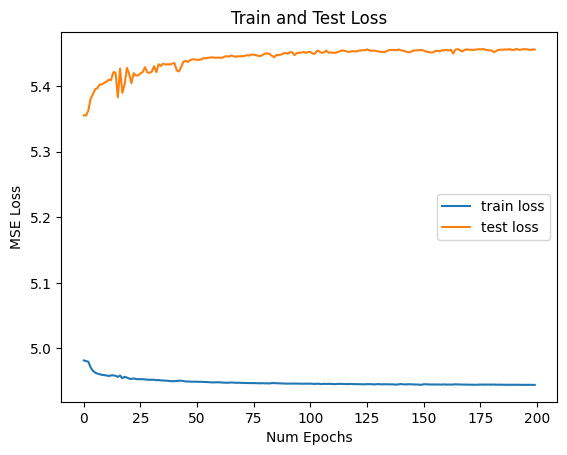

In [23]:
# plot train and test loss

plt.plot(train_loss_lst, label='train loss')
plt.plot(test_loss_lst, label='test loss')
plt.xlabel('Num Epochs')
plt.ylabel('MSE Loss')
plt.title('Train and Test Loss')
plt.legend()
plt.show()

In [23]:
predictions_y = []
input_x = []
value_y = []
mse = []
# Make predictions
with torch.no_grad():
    for test_task in test_dataset:
        context = test_task[:context_size]
        target_x = test_task[context_size:, 0].unsqueeze(1)
        target_y = test_task[context_size:, 1].unsqueeze(1)
        # gamma_beta_dict = adaptiveNetwork.forward(context[:, 0], context[:, 1])
        input_x.append(target_x)
        value_y.append(target_y)
        predictions = baseModel(target_x)
        predictions_y.append(predictions)
        # find the rmse between the predictions and the actual values
        mse.append(torch.sqrt(torch.mean((predictions - target_y)**2)))
        # print mse till 4 decimal places
        # print('RMSE: {:.4f}'.format(torch.sqrt(torch.mean((predictions - value_y)**2))))        

/tmp/ipykernel_1083998/476468703.py:2: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(hspace=0.7)


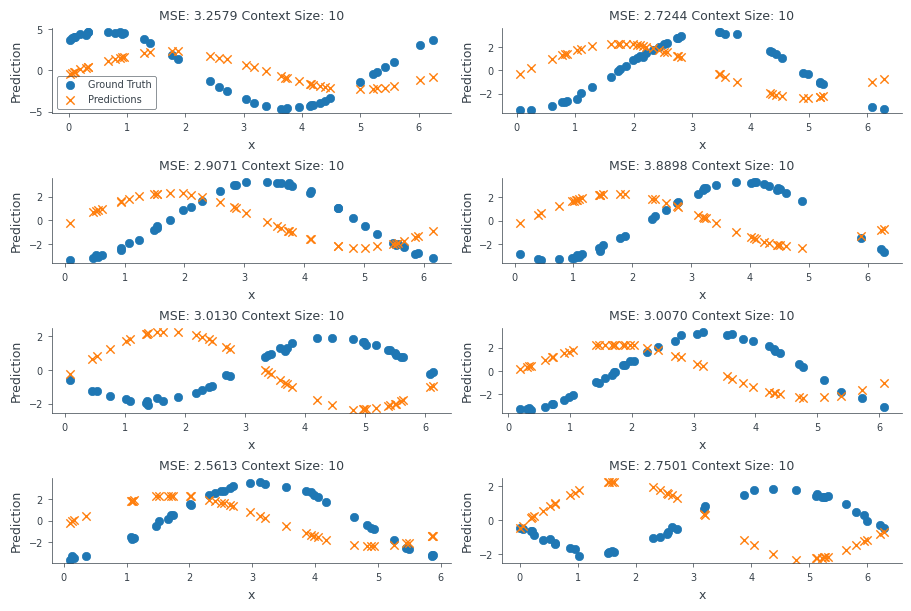

In [27]:
plt.figure(figsize=(9, 6))
plt.subplots_adjust(hspace=0.7)
# plt.subplots_adjust(hspace=0.5)

for i in range(8):
    plt.subplot(4,2, i+1)
    if i == 0:
        plt.scatter(input_x[i*10].cpu(), value_y[i*10].cpu(), marker='o', color='tab:blue', label='Ground Truth')
        plt.scatter(input_x[i*10].cpu(), predictions_y[i*10].cpu(), marker='x', color='tab:orange', label='Predictions')
        plt.legend()
    else:
        plt.scatter(input_x[i*10].cpu(), value_y[i*10].cpu(), marker='o', color='tab:blue', label='Ground Truth')
        plt.scatter(input_x[i*10].cpu(), predictions_y[i*10].cpu(), marker='x', color='tab:orange', label='Predictions')
    plt.xlabel('x')
    plt.ylabel('Prediction')
    # plt.title('Function $y = A*sin(x + phi)$'.format(i))
    plt.title(f'MSE: {mse[i*10]:.4f} Context Size: {context_size}')
    

plt.savefig('reg_result_basemodel.pdf', bbox_inches='tight', transparent=True)

# No

In [ ]:
# #               [A, w, phi, B]
# sine_params = [ [1, 1, 0, 0],           # 0
#                 [2, 1, 0, 0],           # 1
#                 [1, 2, 0, 0],           # 2
#                 [0.9, 1.5, 0.3, 0.5],   # 3
#                 [1, 1, 2, 0],         # 4
#                 [4, 0.6, 0.9, -2],      # 5
#                 [1.7, 4, 3.17, 0],       # 6
#                 [3, 2, 2.19, 0.1],      # 7
#                 [2, 1.5, 0, 0.5],       # 8
#                 [2.5, 3, 3, 2],         # 9
#                 [1.2, 1, 0, 0.8]]       # 10

In [ ]:
# class betaAdaptationNetwork(nn.Module):
#     def __init__(self, input_size, hidden_size):
#         super(betaAdaptationNetwork, self).__init__()
#         self.fc1 = nn.Linear(input_size, hidden_size)
#         self.relu = nn.ReLU()
#         self.fc2 = nn.Linear(hidden_size, hidden_size)  # Output layer with one node for regression
#         self.fc3 = nn.Linear(hidden_size, hidden_size)  # Output layer with one node for regression
#         self.fc4 = nn.Linear(hidden_size, 128)  # Output layer with one node for regression
        
#     def forward(self, embeddings):
#         out = self.fc1(embeddings)
#         out = self.relu(out)
#         out = self.fc2(out)
#         out = self.relu(out)
#         out = self.fc3(out)
#         out = self.relu(out)
#         out = self.fc4(out)
#         return out

In [ ]:
# def get_sine(A, B, w, phi, x):
#     torch.manual_seed(0)
#     return A * torch.sin(w * x + phi) + B + torch.randn(x.shape) * 0.1

In [ ]:
# # Hyperparameters
# input_size = 1  # One input feature
# hidden_size = 128  # Number of neurons in each hidden layer
# learning_rate = 0.01
# num_epochs = 5000

# # Generate synthetic data for regression
# torch.manual_seed(0)
# A = 2.0
# B = 1.0
# w = 2.0
# phi = 0.1
# upper_bound = 2 * torch.pi / w
# X = torch.linspace(0, upper_bound, 100).reshape(100, input_size)
# y = get_sine(A, B, w, phi, X)  # Sine function with noise


# # Initialize the MLP regression model
# # model = MLPRegressor(input_size, hidden_size)
# model = adaptiveMLPRegressor(input_size, hidden_size)

# # Loss and optimizer
# criterion = nn.MSELoss()  # Mean Squared Error loss for regression
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# # Training loop
# for epoch in range(num_epochs):
#     # Forward pass
#     # outputs = model(X)
#     outputs = model(X, y)
#     loss = criterion(outputs, y)

#     # Backward pass and optimization
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()

#     if (epoch + 1) % 100 == 0:
#         print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# # Make predictions
# with torch.no_grad():
#     # predicted = model(X)
#     predicted = model(X, y)

# # print("Predicted values:")
# # print(predicted)

# # Save the trained model
# torch.save(model.state_dict(), 'checkpoints/mlp_regression_model_5hiddenlayers.ckpt')
# print('MLP regression model with 5 hidden layers trained and saved!')

In [ ]:
# # plot x and y
# plt.plot(X, y, 'ro', label='Original data')
# plt.plot(X, predicted, 'bo', label='Fitted line')
# plt.legend()
# plt.show()

In [ ]:
# class CNAPSRegression(nn.Module):
#     def __init__(self, input_size, hidden_size, num_tasks):
#         super(CNAPSRegression, self).__init__()
#         self.num_tasks = num_tasks
#         self.task_embeddings = nn.Embedding(num_tasks, hidden_size)
#         self.mlp = MLPRegressor(input_size + hidden_size, hidden_size)

#     def forward(self, x, task):
#         task_embedding = self.task_embeddings(task)
#         out = torch.cat((x, task_embedding), dim=1)
#         out = self.mlp(out)
#         return out

In [ ]:
# class Encoder(nn.Module):
#     def __init__(self, input_size, hidden_size = 64):
#         super(Encoder, self).__init__()
#         self.fc1 = nn.Linear(input_size, hidden_size)
#         self.relu = nn.ReLU()
#         self.fc2 = nn.Linear(hidden_size, hidden_size)
#         self.fc3 = nn.Linear(hidden_size, 1)

#     def forward(self, x):
#         out = self.fc1(x)
#         out = self.relu(out)
#         out = self.fc2(out)
#         out = self.relu(out)
#         out = self.fc3(out)
#         return out

In [ ]:
# class FiLM(nn.Module):
#     def __init__(self, input_size=3, hidden_size = 64):    # input_size = 3 corresponding to (x, y, encoder_output)
#         super(FiLM, self).__init__()
#         self.fc1 = nn.Linear(input_size, hidden_size)
#         self.relu = nn.ReLU()
#         self.fc2 = nn.Linear(hidden_size, hidden_size)
#         self.fc3 = nn.Linear(hidden_size, 2)

#     def forward(self, x):
#         out = self.fc1(x)
#         out = self.relu(out)
#         out = self.fc2(out)
#         out = self.relu(out)
#         out = self.fc3(out)
#         return out